---
<center><h1>Représentation vectorielle du texte BEDIA JULIEN</h1></center>

---
## Sujet

Dans la leçon précédente, nous avons appris à utiliser plusieurs librairies pour prétraiter du texte. Cependant, nous ne sommes jamais allés au-delà de la *représentation du texte* - nous n'avons manipulé que la représentation elle-même. Si nous voulons effectuer une analyse computationnelle sur le texte, nous devrons concevoir des approches pour convertir le texte en une *représentation numérique*.

Dans cette leçon, nous allons explorer deux moyens parmi les plus simples pour générer une représentation numérique à partir d'un texte : le **sac de mots(bag-of-words)** et **tf-idf**.

Pour ce faire, nous utiliserons abondamment le paquet `scikit-learn`, car il fournit un cadre agréable pour construire les représentations numériques.

## Compétences visées

- Découvrir les différentes formes que peuvent revétir un chatbot

## L'ensemble de données sur les tweets des compagnies aériennes

Nous allons travailler avec un ensemble de données constitué de tweets sur les compagnies aériennes américaines. Chaque échantillon est un tweet différent, qui a été posté sur une compagnie aérienne spécifique. Ces tweets peuvent exprimer un "sentiment" positif, neutre ou négatif.

Notez que ce jeu de données, dans l'ensemble, est bien structuré et a déjà subi un certain nettoyage. Cependant, ce n'est pas la norme dans la science des données de la vie réelle ! Nous avons choisi ce jeu de données afin de pouvoir nous concentrer sur la compréhension des concepts de base.

Chargez le fichier `airline_tweets.csv`

In [2]:
import pandas as pd

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S -0800')


tweets = pd.read_csv('airline_tweets.csv', encoding='utf-8', parse_dates=['tweet_created'], date_parser=dateparse)

## Analyse exploratoire des données

Avant de procéder à un prétraitement ou à une modélisation, nous devons toujours effectuer une analyse exploratoire des données pour nous faire une idée de l'ensemble de données.

Tout d'abord, jetez un coup d'œil aux premières lignes et à toutes les colonnes 

In [41]:
print("Nombre de tweets : ", len(tweets))

print("5 premières lignes : ", tweets.head(5))

print("Colonnes : ", tweets.head().columns)


Nombre de tweets :  14640
5 premières lignes :               tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN   

Nous avons un `tweet_id`, qui identifie de façon unique chaque tweet. Nous avons également un `airline_sentiment`, qui prend les valeurs de `"positive"`, `"negative"`, ou `"neutral"`. Il existe d'autres colonnes indiquant l'auteur du tweet, sa date de création, le fuseau horaire de l'utilisateur, et d'autres encore. La colonne la plus intéressante est la colonne `text` : ce sont les tweets. Jetez un coup d'oeil à quelques-uns

In [11]:
print("5 premieres valeurs de la colonnes text (contenu des tweets) ", tweets['text'][:5])

5 premieres valeurs de la colonnes text (contenu des tweets)  0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object


Observez quelles sont les compagnies aériennes qui font l'objet de tweets et combien de tweets ont été affectés à chaque compagnie.

In [16]:
airline_companies = tweets['airline'].unique()
print(airline_companies)

# On compte le nombre de tweets par compagnie aérienne
tweets_per_airline = tweets['airline'].value_counts()
print(tweets_per_airline)



['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


---

#### Défi 1 : Apprendre à connaître les données

Utilisez `pandas` pour trouver les informations suivantes sur les tweets des compagnies aériennes :

* Combien y a-t-il de tweets dans l'ensemble de données ?
* Combien de tweets sont positifs, neutres et négatifs ?
* Quelle *proportion* de tweets est positive, neutre et négative ?
* Faites un diagramme à barres montrant la proportion des sentiments des tweets.
* Combien de temps sépare les premiers et les derniers tweets ?
* Qu'est-ce qui obtient le plus de retweets : les tweets positifs, négatifs ou neutres ?
* Identifiez la compagnie aérienne dont les tweets ont la plus grande proportion de sentiments négatifs.

---

Nombre de tweets :  14640
Tweets sentiments : 
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
Tweets sentiments (en pourcentage) : 
negative    62.691257
neutral     21.168033
positive    16.140710
Name: airline_sentiment, dtype: float64
Temps séparants le premier et dernier tweet : 
7 days 12:17:32
Type de tweets qui obtient le plus de retweets : 
11596    negative
Name: airline_sentiment, dtype: object
airline_sentiment  negative  neutral  positive  negative_proportion
airline                                                            
American               1960      463       336             0.710402
Delta                   955      723       544             0.429793
Southwest              1186      664       570             0.490083
US Airways             2263      381       269             0.776862
United                 2633      697       492             0.688906
Virgin America          181      171       152             0.359127
Compag

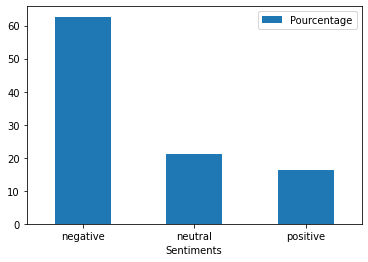

In [95]:
print("Nombre de tweets : ", tweets.count().max())

print("Tweets sentiments : ")
print(tweets['airline_sentiment'].value_counts())

print("Tweets sentiments (en pourcentage) : ")
print(tweets['airline_sentiment'].value_counts(normalize=True) * 100)

airline_sentiment = tweets['airline_sentiment'].value_counts(normalize=True)
x = list(airline_sentiment.index.values.astype(str))  
y = list(airline_sentiment.values * 100)

tweets_percentage = pd.DataFrame({'Sentiments': x, 'Pourcentage': y})
tweets_percentage.plot.bar(x='Sentiments', y='Pourcentage', rot=0)

print("Temps séparants le premier et dernier tweet : ")
print(tweets['tweet_created'].max() - tweets['tweet_created'].min())

print("Type de tweets qui obtient le plus de retweets : ")
print(tweets[tweets['retweet_count'] == tweets['retweet_count'].max()]['airline_sentiment'])

# Création d'un dataframe contenant les sentiments des tweets par compagnie aérienne
sentiments_by_airline = tweets.groupby(['airline', 'airline_sentiment'])['tweet_id'].count().unstack()
# Calcul de la proportion de tweets négatifs par compagnie aérienne en fonction des autres sentiments
sentiments_by_airline['negative_proportion'] = sentiments_by_airline['negative'] / sentiments_by_airline.sum(axis=1)
print(sentiments_by_airline)
most_negative_airline = sentiments_by_airline['negative_proportion'].idxmax()
print("Compagnie aérienne qui obtient la plus grande proportions de tweets négatifs : ", most_negative_airline)



## Prétraitement

Nous avons passé une grande partie des derniers notebooks à apprendre comment prétraiter les données. Appliquons ce que nous avons appris à ce jeu de données. En regardant certains des tweets ci-dessus, nous pouvons voir que même s'ils sont en assez bon état, nous pouvons leur appliquer un traitement supplémentaire.

Dans notre pipeline, nous allons omettre le processus de tokénisation, puisque nous l'effectuerons dans une étape ultérieure. Au lieu de cela, nous allons ajouter quelques nouvelles étapes de prétraitement maintenant que nous travaillons avec des données de médias sociaux. Plus précisément, nous remplacerons tous les hashtags par un jeton "HASHTAG" et nous remplacerons tous les utilisateurs (désignés par le symbole "@") par un jeton "USER". 

---

### Défi 2 : Création d'un pipeline de prétraitement pour les données des médias sociaux

Ecrivez une fonction appelée `preprocess()` qui effectue les opérations suivantes sur une entrée de texte :

* Mettre le texte en minuscules.
* Remplacer toutes les URL par le jeton "URL".
* Remplacer tous les nombres par le jeton "DIGIT".
* Remplacer les hashtags par le jeton "HASHTAG".
* Remplacer tous les utilisateurs par le jeton "USER".
* Supprimer les espaces vides.


Exécutez votre fonction `preprocess()` sur l'exemple suivant:

"lol @toto and @frankl are like soo 800 #today #left get it on https://fb.com #gogo"

Quand vous pensez qu'elle fonctionne, appliquez-la à la colonne `text` entière dans le DataFrame tweets et le résultat est stockée dans une nouvelle colonne `text_processed`.

---

In [3]:
import re

def preprocess(text):
    text = text.lower()

    # Expression régulière pour identifier les URLs
    url_regex = r'http\S+'
    text = re.sub(url_regex, "URL", text)

    # Expression régulière pour identifier les chiffres
    digit_regex = r'\d+'
    text = re.sub(digit_regex, "DIGIT", text)

    # Expression régulière pour identifier les hashtags
    hashtag_regex = r'#\w+'
    text = re.sub(hashtag_regex, "HASHTAG", text)

    # Expression régulière pour identifier les Users
    user_regex = r'@\S+'
    text = re.sub(user_regex, "USER", text)

    text = text.strip()

    # Fonction pour faire la subsititution
    return text

tweets['text_processed'] = tweets['text'].apply(preprocess)

print(tweets['text_processed'][:5])

0                                 USER what USER said.
1    USER plus you've added commercials to the expe...
2    USER i didn't today... must mean i need to tak...
3    USER it's really aggressive to blast obnoxious...
4        USER and it's a really big bad thing about it
Name: text_processed, dtype: object


## La représentation en sac de mots

Le principe fondamental du sac de mots est d'encoder le corpus en termes de fréquences de mots. Prenons le cas du sentiment : nous savons que le sentiment est véhiculé plus fortement par des mots spécifiques. Par exemple, si un tweet contient le mot "heureux", il est susceptible de véhiculer un sentiment positif (mais pas toujours - quelqu'un pourrait dire qu'il n'est "pas heureux" - le sentiment opposé !) En outre, lorsque ces mots reviennent plus souvent, ils véhiculent probablement un sentiment plus fort.

Dans un sac de mots, nous prenons un texte, nous le tokenisons, puis nous tabulons les fréquences de chaque token. La représentation numérique du texte est donc un vecteur indiquant les fréquences de chaque token pour ce texte.


### Matrice document-terme

Dans la plupart des corpus de textes, nous aurons de nombreux échantillons ou *documents*. Par exemple, dans l'ensemble de données de tweets de compagnies aériennes, nous avons de nombreux tweets. Chaque tweet est un échantillon unique en soi : on peut le considérer comme un document unique dans l'ensemble du *corpus*. Comme ils sont tous liés les uns aux autres, de nombreux tokens peuvent être partagés entre les tweets. Ainsi, lors de la création du modèle de sac de mots, nous pouvons effectuer une tokenisation de tous les documents, formant ainsi un *vocabulaire*. Ensuite, nous pouvons représenter un document unique en fonction des tokens du vocabulaire qui sont représentés, et de leur fréquence dans le document.

Si le vocabulaire comporte $V$ tokens, alors chaque document sera encodé dans un vecteur à $V$ dimensions. S'il y a $D$ documents, l'ensemble des données peut être représenté dans une matrice $D \times V$, où chaque ligne correspond au document, et chaque colonne correspond au token (ou "terme"). Cette matrice $D \times V$ est une **matrice document-terme** (DTM).


Pour créer une DTM, nous allons utiliser le `CountVectorizer` du package `sklearn`, une librairie d'apprentissage automatique très utilisé.


In [79]:
from sklearn.feature_extraction.text import CountVectorizer

Si vous n'êtes pas familier avec `sklearn`, voici le flux de travail général :

1. Nous créons d'abord un objet `CountVectorizer`, et choisissons des paramètres spécifiques pour savoir comment nous allons créer la DTM. Consultez la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) pour voir quelles options sont disponibles.
2. Ensuite, nous "ajustons" cet objet `CountVectorizer` aux données. Dans ce contexte, "ajuster" consiste à établir un vocabulaire de tokens à partir des documents de votre jeu de données.
3. Enfin, nous "transformons" les données en fonction de l'objet `CountVectorizer` "ajusté". Cela signifie que nous prenons nos données textuelles et les transformons en une DTM selon le vocabulaire établi par l'étape d'ajustement.
4. Vous pouvez faire les étapes 2 et 3 d'un seul coup en utilisant une fonction `fit_transform`.

Appliquez ce flux à la colonne `text_processed`.

In [100]:
count_vectorizer = CountVectorizer(stop_words='english')

dtm = count_vectorizer.fit_transform(tweets['text_processed'])

print(dtm.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Le résultat obtenu n'est pas exatement un tableau `numpy`. A la place, c'est un tableau `numpy` stocké en CSF (Compressed Sparse Format), autrement dit une matrice éparse. Ce format permet d'économiser beaucoup de mémoire, mais il est difficile à visualiser pour un humain. Pour illustrer les techniques de cette leçon, nous allons d'abord décompresser cette matrice. Cependant, pour les ensembles de données plus importants, il est préférable d'éviter cette opération, car l'utilisation du CSF présente des avantages en termes de performances.

Convertissez la matrice éparse en un tableau `numpy` normal.

In [97]:
import numpy as np

# conversion en tableau numpy
dtm_array = np.array(dtm.toarray())

# affichage du tableau numpy
print(dtm_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Il y a beaucoup de zéros ici ! C'est logique : il y a probablement beaucoup de tokens dans le vocabulaire, et chaque tweet n'a probablement que quelques tokens.

Il serait bon de savoir quelle colonne fait référence à quels tokens. Créez un DataFrame `pandas` qui contient cette information. 

In [98]:
# création du DataFrame des tokens
tokens_df = pd.DataFrame(dtm_array)
tokens_df.columns = count_vectorizer.get_feature_names_out()
# affichage du DataFrame des tokens
print(tokens_df)

       _exact_  aa  aaaand  aadavantage  aadigit  aadigitso  aadv  aadvantage  \
0            0   0       0            0        0          0     0           0   
1            0   0       0            0        0          0     0           0   
2            0   0       0            0        0          0     0           0   
3            0   0       0            0        0          0     0           0   
4            0   0       0            0        0          0     0           0   
...        ...  ..     ...          ...      ...        ...   ...         ...   
14635        0   0       0            0        0          0     0           0   
14636        0   0       0            0        0          0     0           0   
14637        0   0       0            0        0          0     0           0   
14638        0   0       0            0        0          0     0           0   
14639        0   0       0            0        0          0     0           0   

       aal  aaldigit  ...  

Que pouvons-nous faire avec la DTM ? Tout d'abord, nous pouvons voir les tokens les plus fréquents. 

Afficher les 10 tokens les plus fréquents avec le nombre d'apparition associé.

In [99]:
# les 10 tokens les plus fréquents sans les mots vides
print(tokens_df.sum().sort_values(ascending=False)[:10])

user         16485
digit         6220
flight        3924
hashtag       3470
url           1211
thanks        1078
cancelled     1057
just           974
service        965
help           852
dtype: int64


BONUS

- Quel token sans hashtag et sans chiffre apparaît le plus souvent dans un tweet donné ? 
- Combien de fois apparaît-il ? 
- Quel est le tweet original ?

In [27]:
import re

def get_most_common_token(tweet):
    # éliminer les tokens qui contiennent des hashtags ou des chiffres
    filtered_tokens = [token for token in tweet.split() if not re.search('HASHTAG|DIGIT|USER', token)]
    # compter les occurrences des tokens
    token_counts = {}
    for token in filtered_tokens:
        if token in token_counts:
            token_counts[token] += 1
        else:
            token_counts[token] = 1

    # trouver le token le plus fréquent
    if len(token_counts) == 0:
        return None, 0
    
    most_common_token = max(token_counts, key=token_counts.get)
    count = token_counts[most_common_token]

    return most_common_token, count

# Pour chaque tweets on regarde quel token apparait le plus souvent et combien de fois mis à part HASHTAG et DIGIT
pair = tweets['text_processed'].apply(get_most_common_token)
tweets['most_common_token'] = pair.apply(lambda x: x[0])
tweets['most_common_token_count'] = pair.apply(lambda x: x[1])

print(tweets['most_common_token'][:5])
print(tweets['most_common_token_count'][:5])

# Calcul du nombre de fois ou le token le plus fréquent apparait
t = tweets['most_common_token_count'].sort_values(ascending=False)


# récupére l'index du token le plus fréquent
index = t.index[0]
print("Token le plus fréquent : " + tweets['most_common_token'][index])

# affiche le tweet correspondant
print("Tweets correspondants : " + tweets['text_processed'][index])

print(t[:10])

0    what
1    plus
2       i
3    it's
4     and
Name: most_common_token, dtype: object
0    1
1    1
2    2
3    1
4    1
Name: most_common_token_count, dtype: int64
Token le plus fréquent : to
Tweets correspondants : USER lost bag on flight to vegas. now to el paso. going to dallas love. gate attendant said see if can coordinate to get it to love
5180     5
220      5
3412     5
7566     5
13715    5
537      5
10260    5
12548    5
13520    5
13925    5
Name: most_common_token_count, dtype: int64


C:\Users\Julien\AppData\Local\Temp\ipykernel_3976\1532080745.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(t[:10])
